# Load Data

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
#!unzip /content/gdrive/MyDrive/data.zip -d /content

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE




train = pd.read_csv('/content/open/train.csv')
test = pd.read_csv('/content/open/test.csv')

In [ ]:
print(test.shape, train.shape)

ncols = train.shape[1]
nrows = train.shape[0]

print(nrows,ncols)

(10000, 19) (26457, 20)
26457 20


# Data Cleansing

In [ ]:
test.head(5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [ ]:
train.drop(['index','FLAG_MOBIL'],axis = 1, inplace=True)
test.drop(['index','FLAG_MOBIL'],axis = 1, inplace=True)

In [ ]:
train.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

##무직자 처리

In [ ]:

##'Days_Employed'가 플러스인 사람은 무직자로 처리하였습니다.
def convert(x):
  if x>0:
    return 0
  else:
    return x

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : 0 if x>0 else x )
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x : 0 if x>0 else x)

In [ ]:
train.loc[(train['DAYS_EMPLOYED']==0),'occyp_type'] = 'Unemployed'
test.loc[(train['DAYS_EMPLOYED']==0),'occyp_type'] = 'Unemployed'

In [ ]:
train.occyp_type.fillna('NAN', inplace=True)
test.occyp_type.fillna('NAN', inplace=True)

##음수를 양수로 변환

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(abs)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(abs)
train['begin_month'] = train['begin_month'].apply(abs)

test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(abs)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(abs)
test['begin_month'] = test['begin_month'].apply(abs)

##Birthday/Work Experience

In [ ]:
# def birthday(x):
#   temp = []
#   yy = 2020 - (x//365)
#   temp.append(str(yy))
  
#   if x%365<30:
#     month = 1
#   else:
#     month = (x%365)//30
#   temp.append(str(month))
  
#   day = (x%365)%30
#   temp.append(str(day))

#   return '/'.join(temp)
def age(x):
  x = x//365
  return x
def year_experience(x):
  x = x//365
  return x

In [ ]:
train['Age'] = train['DAYS_BIRTH'].apply(age)
train.drop('DAYS_BIRTH', axis = 1, inplace = True)
test['Age'] = test['DAYS_BIRTH'].apply(age)
test.drop('DAYS_BIRTH', axis = 1, inplace = True)


train['YEARS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(year_experience)
train.drop('DAYS_EMPLOYED', axis = 1, inplace = True)
test['YEARS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(year_experience)
test.drop('DAYS_EMPLOYED', axis = 1, inplace = True)

## ID 파생변수 생성

Since one person could have made several credit cards, I checked if there are any duplicates of each row after excluding two columns credit and date credit card was made.

In [ ]:
train['ID'] = train['gender'] + train['edu_type'] + train['Age'].astype(str)+train['income_total'].astype(str) + train['income_type'] + train['occyp_type'] + train['YEARS_EMPLOYED'].astype(str) 


##begin_month 평균치로 대체

In [ ]:
temp = pd.DataFrame(train.groupby('ID').begin_month.mean().round())
train.drop('begin_month',axis=1,inplace=True)
train = pd.merge(train,temp,left_on='ID', right_index=True , how='left')
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,credit,Age,YEARS_EMPLOYED,ID,begin_month
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,0,NAN,2.0,1.0,38,12,FHigher education38202500.0Commercial associat...,33.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Laborers,3.0,1.0,31,4,FSecondary / secondary special31247500.0Commer...,7.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,0,1,0,Managers,2.0,2.0,52,12,MHigher education52450000.0WorkingManagers12,29.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,Sales staff,2.0,0.0,41,5,FSecondary / secondary special41202500.0Commer...,44.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,0,0,0,Managers,2.0,2.0,41,5,FHigher education41157500.0State servantManagers5,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,0,0,0,Core staff,4.0,1.0,33,5,FSecondary / secondary special33225000.0State ...,24.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,0,0,0,NAN,2.0,2.0,41,6,FHigher education41180000.0WorkingNAN6,47.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,0,0,0,Core staff,2.0,2.0,27,5,FSecondary / secondary special27292500.0Workin...,25.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,0,0,0,Laborers,1.0,2.0,27,0,MIncomplete higher27171000.0WorkingLaborers0,59.0


##credit 평균치로 대체

In [ ]:
temp = pd.DataFrame(train.groupby(['ID']).credit.mean().round())
train.drop('credit',axis=1,inplace=True)
train = pd.merge(train,temp,left_on='ID', right_index=True , how='left')
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,Age,YEARS_EMPLOYED,ID,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,0,NAN,2.0,38,12,FHigher education38202500.0Commercial associat...,33.0,2.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Laborers,3.0,31,4,FSecondary / secondary special31247500.0Commer...,7.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,0,1,0,Managers,2.0,52,12,MHigher education52450000.0WorkingManagers12,29.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,Sales staff,2.0,41,5,FSecondary / secondary special41202500.0Commer...,44.0,1.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,0,0,0,Managers,2.0,41,5,FHigher education41157500.0State servantManagers5,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,0,0,0,Core staff,4.0,33,5,FSecondary / secondary special33225000.0State ...,24.0,2.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,0,0,0,NAN,2.0,41,6,FHigher education41180000.0WorkingNAN6,47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,0,0,0,Core staff,2.0,27,5,FSecondary / secondary special27292500.0Workin...,25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,0,0,0,Laborers,1.0,27,0,MIncomplete higher27171000.0WorkingLaborers0,59.0,2.0


##중복 ID 제거

In [ ]:
train.drop_duplicates('ID',inplace = True)

In [ ]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,Age,YEARS_EMPLOYED,ID,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,0,NAN,2.0,38,12,FHigher education38202500.0Commercial associat...,33.0,2.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Laborers,3.0,31,4,FSecondary / secondary special31247500.0Commer...,7.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,0,1,0,Managers,2.0,52,12,MHigher education52450000.0WorkingManagers12,29.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,Sales staff,2.0,41,5,FSecondary / secondary special41202500.0Commer...,44.0,1.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,0,0,0,Managers,2.0,41,5,FHigher education41157500.0State servantManagers5,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,F,N,N,0,225000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,0,Laborers,1.0,28,1,FSecondary / secondary special28225000.0Commer...,37.0,2.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,0,0,0,NAN,2.0,41,6,FHigher education41180000.0WorkingNAN6,47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,0,0,0,Core staff,2.0,27,5,FSecondary / secondary special27292500.0Workin...,25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,0,0,0,Laborers,1.0,27,0,MIncomplete higher27171000.0WorkingLaborers0,59.0,2.0


#Outliers

###Child_num outliers

In [ ]:
train.child_num.unique()

array([ 0,  1,  2,  3,  4,  5, 14, 19,  7])

In [ ]:
# I considered people with more than 5 children as outliers 

train.drop(train.loc[train['child_num']>5].index,inplace=True)


In [ ]:
train.shape

(8005, 19)

### Income_total outliers

In [ ]:
from scipy import stats
stats.shapiro(train['income_total'])[1] 
# Since its less than 0.05, it shows that the data is not normally distributed
# Thus, we need to transform the data 


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


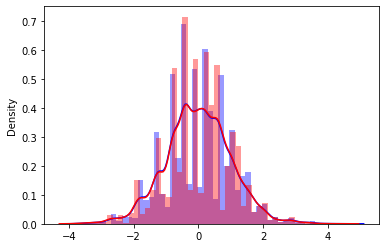

In [ ]:
sns.distplot(stats.zscore(np.log(train['income_total'])), color = 'blue')
sns.distplot(stats.zscore(stats.boxcox(train['income_total'])[0]), color = 'red')



In [ ]:
train['income_total'] = stats.zscore(stats.boxcox(train['income_total'])[0])
min = train['income_total'].min()
max = train['income_total'].max()

test['income_total'] = stats.zscore(stats.boxcox(test['income_total'])[0])
test_min = test['income_total'].min()
test_max = test['income_total'].max()

In [ ]:
train['income_total'] = pd.cut(train['income_total'],
                     bins=[min,-3,-2,-1, 1, 2, 3, max],
                     labels=['very_low','low','mid_low','med','med_high','high','very_high'])

In [ ]:
test['income_total'] = pd.cut(test['income_total'],
                     bins=[test_min,-3,-2,-1, 1, 2, 3, test_max],
                     labels=['very_low','low','mid_low','med','med_high','high','very_high'])

In [ ]:
train.income_total.value_counts()

med          5445
med_high     1168
mid_low      1021
high          184
low           139
very_high      26
very_low       20
Name: income_total, dtype: int64

count     8003
unique       7
top        med
freq      5445
Name: income_total, dtype: object 



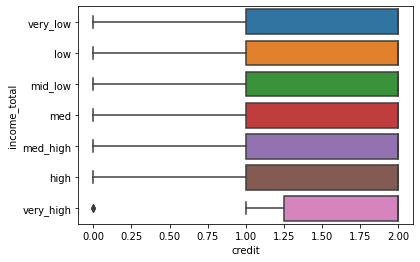

In [ ]:
print(train['income_total'].describe() ,'\n')

sns.boxplot(x='credit', y='income_total', data=train)


#Encoding

In [ ]:
train.drop('ID', axis = 1, inplace=True)

In [ ]:
encoder = LabelEncoder()
train['income_total'] = train['income_total'].astype('str')
train['income_total'] = encoder.fit_transform(train['income_total'].values)

test['income_total'] = test['income_total'].astype('str')
test['income_total'] = encoder.fit_transform(test['income_total'].values)



In [ ]:

object_feats = train.dtypes[train.dtypes == "object"].index.tolist()
object_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('income_total')


In [ ]:
def dummies(df,column):
  dummy = pd.get_dummies(df[column],prefix = column)
  df = pd.concat([df,dummy], axis= 1) 
  df.drop(column, axis=1, inplace = True)
  return df

for i in object_feats:
  train = dummies(train,i)
  test = dummies(test,i)


In [ ]:

y = train['credit']
x = train.drop('credit',axis = 1)



# Scaling

In [ ]:

X = preprocessing.StandardScaler().fit(x).transform(x)
test = preprocessing.StandardScaler().fit(test).transform(test)

X

array([[-0.60521143, -0.42029016, -0.55479081, ..., -0.14005476,
        -0.3487402 , -0.06626815],
       [ 0.74166583, -0.42029016, -0.55479081, ..., -0.14005476,
        -0.3487402 , -0.06626815],
       [-0.60521143, -2.73022679, -0.55479081, ..., -0.14005476,
        -0.3487402 , -0.06626815],
       ...,
       [-0.60521143,  0.73467816, -0.55479081, ..., -0.14005476,
        -0.3487402 , -0.06626815],
       [-0.60521143, -0.42029016, -0.55479081, ..., -0.14005476,
        -0.3487402 , -0.06626815],
       [-0.60521143,  1.88964648, -0.55479081, ...,  7.14006439,
        -0.3487402 , -0.06626815]])

#Modeling


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,
                                                 random_state = 33)

In [ ]:
smote = SMOTE(random_state = 0 )
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_over.shape
y_train_over.shape

(11190, 56)

In [ ]:

rftree = RandomForestClassifier() 

parameters = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
grid_dtree = GridSearchCV(rftree, param_grid=parameters, cv=3, refit=True,  n_jobs = -1, verbose = 2 )


In [ ]:
grid_dtree.fit( X_train_over, y_train_over)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  4.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
#Result

print('Best score :', grid_dtree.best_score_, end='\n\n')
print('Best parameters :')
grid_dtree.best_params_

Best score : 0.6857043538034467

Best parameters :


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
#Result details

res1 = pd.DataFrame(grid_dtree.cv_results_)
res1.sort_values(by=['rank_test_score'], inplace=True)
res1[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
185,"{'bootstrap': True, 'max_depth': 100, 'max_fea...",0.685704,1
188,"{'bootstrap': True, 'max_depth': 100, 'max_fea...",0.685704,2
39,"{'bootstrap': True, 'max_depth': 80, 'max_feat...",0.684990,3
46,"{'bootstrap': True, 'max_depth': 80, 'max_feat...",0.684990,4
114,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",0.684990,5


In [ ]:
y_hat = grid_dtree.predict_proba(test)  
y_hat.tolist()

[[0.06913985917451054, 0.24521663366706703, 0.6856435071584224],
 [0.1234113889981061, 0.22002339433908372, 0.6565652166628101],
 [0.12483339556841415, 0.2650354546462294, 0.6101311497853564],
 [0.06992696937578624, 0.22002478250114613, 0.7100482481230677],
 [0.07612308983916857, 0.2568627831540709, 0.6670141270067605],
 [0.0537357231294307, 0.2783373931385606, 0.6679268837320086],
 [0.058340081955599955, 0.26767999921684416, 0.6739799188275561],
 [0.07131137159368761, 0.20509878122911687, 0.723589847177195],
 [0.0638879445684854, 0.2144369510077616, 0.7216751044237527],
 [0.07686707967162511, 0.24650527980043446, 0.6766276405279399],
 [0.05506973262371376, 0.23229044706873447, 0.7126398203075519],
 [0.10689174869414836, 0.17976688398185722, 0.7133413673239943],
 [0.13170763553195455, 0.2742580623592193, 0.594034302108826],
 [0.04480591056028746, 0.28466934159839935, 0.6705247478413131],
 [0.06745354695275436, 0.2682144108676711, 0.6643320421795746],
 [0.06463746142299077, 0.2555497993

In [ ]:
submission = pd.read_csv('/content/open/sample_submission.csv',index_col = 'index')
submission = pd.DataFrame(
        index = submission.index,
        columns = [0,1,2],
        data = y_hat.tolist(),)
submission.reset_index(level = 0, inplace = True)
submission.to_csv('/content/gdrive/MyDrive/submission.csv', index = False)
submission


,index,0,1,2
0,26457,0.069140,0.245217,0.685644
1,26458,0.123411,0.220023,0.656565
2,26459,0.124833,0.265035,0.610131
3,26460,0.069927,0.220025,0.710048
4,26461,0.076123,0.256863,0.667014
...,...,...,...,...
9995,36452,0.079680,0.244952,0.675368
9996,36453,0.081795,0.201145,0.717060
9997,36454,0.062202,0.193586,0.744211
9998,36455,0.045821,0.264127,0.690052
